<a href="https://colab.research.google.com/github/RutujKhare1/CS6910_Assignment_1/blob/main/FDL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=376ef2b27e00efde524b221aa42563057f55379b2b7aee3512023e789c454a64
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [28]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import wandb



In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
num_label = 10
num_samples = len(X_train)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print("Train shape : {}, {}".format(X_train.shape, Y_train.shape))
print("Test shape : {}, {}".format(X_test.shape, Y_test.shape))

Train shape : (60000, 28, 28), (60000,)
Test shape : (10000, 28, 28), (10000,)


# Question 1

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs22m074 (team_exe). Use `wandb login --relogin` to force relogin


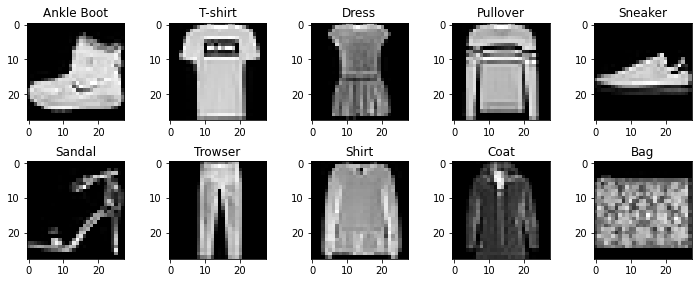

In [5]:
num_row = 2
num_col = 5

cnt = 0
images = X_train
labels = Y_train
dic = {0:'T-shirt', 1:'Trowser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}
wandb.login(key = '5b3ff6cba361172038b8948f6dace9286a5bbfa0')
temp_labels = []
r_idx = 0
c_idx = 0
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col, 2*num_row))
idx = 0
while (cnt<10 and idx < 60000):
  if(labels[idx] not in temp_labels):
    if(c_idx == num_col):
      r_idx = 1
      c_idx = 0
    wandb.init(project = "dl-project_images")
    wandb.log({'Images' : [wandb.Image(images[idx], caption = dic[labels[idx]])]})
    temp_labels.append([labels[idx]])
    ax = axes[r_idx, c_idx]
    ax.imshow(images[idx], cmap='gray')
    ax.set_title('{}'.format(dic[labels[idx]]))
    c_idx += 1
    cnt += 1
  idx += 1 
wandb.finish()
plt.tight_layout()
plt.show()

#Question 2

In [8]:
#Helper functions

def xavierRandom(x, y):
  limit = np.sqrt(6 / float(x + y))
  return np.random.uniform(low=-limit, high=limit, size=(x,y))
  

In [9]:
#activation functions

def sigmoid(x):
  z = x.copy()
  z[x < 0] = np.exp(x[x < 0])/(1 + np.exp(x[x<0]))
  z[x >= 0] = 1/(1+np.exp(-x[x >= 0]))
  return z

def d_sigmoid(x):
  return sigmoid(x)*(1 - sigmoid(x))

def softmax(x):
  e_x = np.exp(x - max(x))
  return e_x / e_x.sum()

def tanh(x):
  return np.tanh(x)
  
def d_tanh(x):
  return 1 - tanh(x)**2

def relu(x):
  return np.maximum(x,0)

def d_relu(x):
  z = x.copy()
  z[x < 0]=0
  z[x > 0]=1
  return z

actFn_dict = {"sigmoid":sigmoid,
               "softmax":softmax,
               "relu":relu,
               "tanh":tanh}
d_actFn_dict = {"sigmoid":d_sigmoid,
               "relu":d_relu,
               "tanh":d_tanh}


In [10]:
class OptimizerHelper:
  def forwardPropagation(self, W, B, X, num_layer, activation):
    H=list()
    A=list()
    a = np.array(W[0]@X.T + B[0])
    h = actFn_dict[activation](a)
    H.append(h)
    A.append(a)
    cur_ip = h

    for i in range(num_layer-1):
      a = np.array(W[i+1]@cur_ip + B[i+1])
      h = actFn_dict[activation](a.T).T
      H.append(h)
      A.append(a)
      cur_ip = h
    a = np.array(W[num_layer]@cur_ip + B[num_layer])
    h = a.T
    A.append(a)
    y = np.array([actFn_dict["softmax"](i) for i in h]).T
    return H, A, y

  def backwardPropagation(self, H, A, y, W, B, X, Y, num_layer, num_label, activation, wt_decay, loss_fn):
    xdim = X.shape[0]
    d_aL = y
    if(loss_fn == "crossEntropy"):
      ey = np.zeros([xdim,num_label], dtype= int)
      for i in range(xdim):
        ey[i][Y[i]] = 1
      d_aL = -(ey.T - y) 
    else:
      ey = np.zeros([xdim,num_label], dtype= int)
      for i in range(xdim):
        ey[i][Y[i]] = 1
      temp = -(ey.T - y)
      d_aL = 2*temp*y*(1-y)

    D_W = list()
    D_B = list()
    for k in reversed(range(1,num_layer+1)):
      d_wL = d_aL@H[k-1].T
      D_W.append(d_wL/xdim)

      d_bL = np.sum(d_aL, axis = 1).reshape(len(d_aL),1)/xdim
      D_B.append(d_bL)
  
      d_hL = W[k].T@d_aL
      dga = d_actFn_dict[activation](A[k-1])
      d_aL = np.multiply(d_hL,dga)

    d_wL = d_aL @ X
    d_bL = d_aL
    d_bL = np.sum(d_bL, axis = 1).reshape(len(d_aL),1)/xdim
    D_W.append(d_wL/xdim)
    D_B.append(d_bL)
    return D_W, D_B

In [11]:
X_mini = np.reshape(X_train, (60000,784))/255.0
num_data_points = 60000
num_labels = 10
num_val_points = num_data_points//10
num_train_points = num_data_points - num_val_points
Xtrain = X_mini[:num_train_points]
Ytrain = Y_train[:num_train_points]
X_valid = X_mini[num_train_points:]
Y_valid =  Y_train[num_train_points:]

In [13]:
class feedforwardNeuralNetwork:
  def __init__(self, num_layers = 3, hidden_size = 64, num_labels = 10, neta = 0.1, epochs = 10, X_train = X_train, Y_train = Y_train, batch = 64, w_init = "xavier", X_val = X_valid, Y_val = Y_valid, activation = 'sigmoid', wt_decay = 0, loss_fn = "crossEntropy"):
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.xdim = X_train.shape[0]
    self.ydim = X_train.shape[1]
    self.num_labels = num_labels
    self.neta = neta
    self.epochs = epochs
    self.X_train = X_train
    self.Y_train = Y_train
    self.X_val = X_val
    self.Y_val = Y_val
    self.batch = batch
    w, b = self.initialiseWeight(w_init)
    self.W = w
    self.B = b
    self.activation = activation
    self.wt_decay = wt_decay
    self.loss_fn = loss_fn
  
  def initialiseWeight(self, method):
    w = list()
    b = list()
    if(method == "xavier"):
      w.append(xavierRandom(self.hidden_size, self.ydim))
      b.append(np.zeros([self.hidden_size,1]))
      for i in range(self.num_layers-1):
        w.append(xavierRandom(self.hidden_size, self.hidden_size))
        b.append(np.zeros([self.hidden_size,1]))
      w.append(xavierRandom(self.num_labels, self.hidden_size))
      b.append(np.zeros([self.num_labels,1]))
    else:
      # w.append(np.random.randn(hidden_size, ydim))
      w.append(np.random.uniform(-1,1, (self.hidden_size, self.ydim)))

      # b.append(np.random.randn(hidden_size,1))
      b.append(np.zeros([self.hidden_size,1]))
      for i in range(self.num_layers-1):
        # w.append(np.random.randn(hidden_size, hidden_size))
        w.append(np.random.uniform(-1,1, (self.hidden_size, self.hidden_size)))
        # b.append(np.random.randn(hidden_size,1))
        b.append(np.zeros([self.hidden_size,1]))
      # w.append(np.random.randn(num_labels, hidden_size))
      w.append(np.random.uniform(-1,1, (self.num_labels, self.hidden_size)))
      # b.append(np.random.randn(num_labels,1))
      b.append(np.zeros([self.num_labels,1])) 
    return w, b

  def calculateCrossEntropy(self, y_hat, Y):
    num_data = y_hat.shape[1]
    Y_one_hot = np.eye(self.num_labels)[Y]
    loss = np.sum(Y_one_hot * np.log(y_hat.T + 1e-15) )
    w_sq = 0
    for i in range(len(self.W)):
      w_sq += np.sum(self.W[i]**2)
    return (-loss + (self.wt_decay*w_sq)/2)/(num_data)

  def calculateMSE(self, y_hat, Y):
    m,n = y_hat.shape
    Y_one_hot = np.eye(self.num_labels)[Y]
    temp = (y_hat.T - Y_one_hot)**2
    loss = np.sum(temp)
    w_sq = 0
    for i in range(len(self.W)):
      w_sq += np.sum(self.W[i]**2)
    return (loss + (self.wt_decay*w_sq)/2)/(n)

  def calculateAccuracy(self, y_hat, Y):
    pred = np.argmax(y_hat, axis=0)
    accuracy = np.mean(pred==Y)
    return accuracy*100

  def feedForward(self, x):
    a = np.array(self.W[0]@x.T + self.B[0])
    h = actFn_dict[self.activation](a.T).T
    cur_ip = h

    for i in range(self.num_layers-1):
      a = np.array(self.W[i+1]@cur_ip + self.B[i+1])
      h = actFn_dict[self.activation](a.T).T
      cur_ip = h
    a = np.array(self.W[self.num_layers]@cur_ip + self.B[self.num_layers])
    h = a.T
    # print(h)
    y = np.array([actFn_dict["softmax"](i) for i in h]).T
    # print(y)
    return y

  # def gradientDescent(self):
  #   for k in range(self.epochs):
  #     O = OptimizerHelper()
  #     H, A, y = O.forwardPropagation(self.W, self.B, self.X_train, self.num_layers)
  #     D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, self.X_train, self.Y_train, self.num_layers, self.num_labels)
  #     D_W = np.flip(D_W)
  #     D_B = np.flip(D_B)
  #     # print(self.B[0].shape)
  #     # print(D_B[0].shape)
  #     for i in range(self.num_layers+1):
  #       self.W[i] = self.W[i] - self.neta*D_W[i]
  #       self.B[i] = self.B[i] - self.neta*D_B[i] 
      
  #     y_hat = self.feedForward(self.X_train)
  #     Y_one_hot = np.eye(self.num_labels)[self.Y_train]
  #     loss = -np.sum(Y_one_hot * np.log(y_hat.T + 1e-15) )
  #     print("Epoch {} : {}".format(k, (loss/self.xdim)))
  

  def momentumGD(self, beta = 0.9, eta = 1.0):
    # print("neta ",self.neta)
    O = OptimizerHelper()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation, self.wt_decay, self.loss_fn)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          uw = D_W
          ub = D_B
        else:
          uw = beta*prev_uw + eta*D_W
          ub = beta*prev_ub + eta*D_B
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*uw[i] - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*ub[i] - self.neta*self.wt_decay*self.B[i]
        prev_uw = uw
        prev_ub = ub 
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
      if(self.loss_fn == "crossEntropy"):
        train_loss.append(self.calculateCrossEntropy(y_train_hat, self.Y_train))
        val_loss.append(self.calculateCrossEntropy(y_val_hat, self.Y_val))
      else:
        train_loss.append(self.calculateMSE(y_train_hat, self.Y_train))
        val_loss.append(self.calculateMSE(y_val_hat, self.Y_val))
      print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
      
      
    return train_loss, train_acc, val_loss, val_acc

  def nagGD(self, beta = 0.1, eta = 1.0):
    O = OptimizerHelper()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        if k==0:
          H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
          D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation, self.wt_decay, self.loss_fn)
        else:
          u_w = beta*prev_uw
          u_b = beta*prev_ub
          temp_u_w = list()
          temp_u_b = list()
          for i in range(len(self.W)):
            temp_u_w.append(self.W[i]-u_w[i])
            temp_u_b.append(self.B[i]-u_b[i])  
          H, A, y = O.forwardPropagation(temp_u_w, temp_u_b, X_batch, self.num_layers, self.activation)
          D_W, D_B = O.backwardPropagation(H, A, y, temp_u_w, temp_u_b, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation)

        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          uw = D_W
          ub = D_B
        else:
          uw = beta*prev_uw + eta*D_W
          ub = beta*prev_ub + eta*D_B
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*uw[i] - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*ub[i] - self.neta*self.wt_decay*self.B[i]
        prev_uw = uw
        prev_ub = ub 
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
      if(self.loss_fn == "crossEntropy"):
        train_loss.append(self.calculateCrossEntropy(y_train_hat, self.Y_train))
        val_loss.append(self.calculateCrossEntropy(y_val_hat, self.Y_val))
      else:
        train_loss.append(self.calculateMSE(y_train_hat, self.Y_train))
        val_loss.append(self.calculateMSE(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc
    
  
  def stochasticGD(self):
    O = OptimizerHelper()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation, self.wt_decay, self.loss_fn)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        # print(self.B[0].shape)
        # print(D_B[0].shape)
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*D_W[i] - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*D_B[i] - self.neta*self.wt_decay*self.B[i]
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
      if(self.loss_fn == "crossEntropy"):
        train_loss.append(self.calculateCrossEntropy(y_train_hat, self.Y_train))
        val_loss.append(self.calculateCrossEntropy(y_val_hat, self.Y_val))
      else:
        train_loss.append(self.calculateMSE(y_train_hat, self.Y_train))
        val_loss.append(self.calculateMSE(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc

  def RMSprop(self, beta = 0.9, eps = 1e-8):
    # print("neta ",self.neta)
    O = OptimizerHelper()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation, self.wt_decay, self.loss_fn)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          uw = (1-beta)*np.square(D_W)
          ub = (1-beta)*np.square(D_B)
        else:
          uw = beta*prev_uw + (1-beta)*np.square(D_W)
          ub = beta*prev_ub + (1-beta)*np.square(D_B)
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*D_W[i]/(np.sqrt(uw[i]) + eps) - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*D_B[i]/(np.sqrt(ub[i]) + eps) - self.neta*self.wt_decay*self.B[i]
        prev_uw = uw
        prev_ub = ub 
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
      if(self.loss_fn == "crossEntropy"):
        train_loss.append(self.calculateCrossEntropy(y_train_hat, self.Y_train))
        val_loss.append(self.calculateCrossEntropy(y_val_hat, self.Y_val))
      else:
        train_loss.append(self.calculateMSE(y_train_hat, self.Y_train))
        val_loss.append(self.calculateMSE(y_val_hat, self.Y_val))
    return train_loss, train_acc, val_loss, val_acc

  def adam(self, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
    # print("neta ",self.neta)
    O = OptimizerHelper()
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation, self.wt_decay, self.loss_fn)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          mw = (1-beta1)*D_W
          mb = (1-beta1)*D_B
          uw = (1-beta2)*np.square(D_W)
          ub = (1-beta2)*np.square(D_B)
        else:
          mw = beta1*mw + (1-beta1)*D_W
          mb = beta1*mb + (1-beta1)*D_B
          uw = beta2*uw + (1-beta2)*np.square(D_W)
          ub = beta2*ub + (1-beta2)*np.square(D_B)

        mw_hat = mw / (1-np.power(beta1,k+1))
        mb_hat = mb / (1-np.power(beta1,k+1))
        uw_hat = uw / (1-np.power(beta2,k+1))
        ub_hat = ub / (1-np.power(beta2,k+1))
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta*mw_hat[i]/(np.sqrt(uw_hat[i]) + eps) - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta*mb_hat[i]/(np.sqrt(ub_hat[i]) + eps) - self.neta*self.wt_decay*self.B[i]
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
      if(self.loss_fn == "crossEntropy"):
        train_loss.append(self.calculateCrossEntropy(y_train_hat, self.Y_train))
        val_loss.append(self.calculateCrossEntropy(y_val_hat, self.Y_val))
      else:
        train_loss.append(self.calculateMSE(y_train_hat, self.Y_train))
        val_loss.append(self.calculateMSE(y_val_hat, self.Y_val))
      print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
    return train_loss, train_acc, val_loss, val_acc

  def nAdam(self, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
    # print("neta ",self.neta)
    val_loss = list()
    val_acc = list()
    train_loss = list()
    train_acc = list()
    O = OptimizerHelper()
    for k in range(self.epochs):
      for b in range(0, self.xdim, self.batch):
        X_batch = self.X_train[b:b+self.batch]
        Y_batch = self.Y_train[b:b+self.batch]
        H, A, y = O.forwardPropagation(self.W, self.B, X_batch, self.num_layers, self.activation)
        D_W, D_B = O.backwardPropagation(H, A, y, self.W, self.B, X_batch, Y_batch, self.num_layers, self.num_labels, self.activation, self.wt_decay, self.loss_fn)
        D_W = np.flip(D_W)
        D_B = np.flip(D_B)
        if k==0:
          mw = (1-beta1)*D_W
          mb = (1-beta1)*D_B
          uw = (1-beta2)*np.square(D_W)
          ub = (1-beta2)*np.square(D_B)
        else:
          mw = beta1*mw + (1-beta1)*D_W
          mb = beta1*mb + (1-beta1)*D_B
          uw = beta2*uw + (1-beta2)*np.square(D_W)
          ub = beta2*ub + (1-beta2)*np.square(D_B)

        mw_hat = mw / (1-np.power(beta1,k+1))
        mb_hat = mb / (1-np.power(beta1,k+1))
        uw_hat = uw / (1-np.power(beta2,k+1))
        ub_hat = ub / (1-np.power(beta2,k+1))
        for i in range(self.num_layers+1):
          self.W[i] = self.W[i] - self.neta/(np.sqrt(uw_hat[i]) + eps)*(beta1*mw_hat[i] + (1-beta1)*D_W[i] / (1-np.power(beta1,k+1))) - self.neta*self.wt_decay*self.W[i]
          self.B[i] = self.B[i] - self.neta/(np.sqrt(ub_hat[i]) + eps)*(beta1*mb_hat[i] + (1-beta1)*D_B[i] / (1-np.power(beta1,k+1))) - self.neta*self.wt_decay*self.B[i] 
      
      y_train_hat = self.feedForward(self.X_train)
      y_val_hat = self.feedForward(self.X_val)
      train_acc.append(self.calculateAccuracy(y_train_hat, self.Y_train))
      val_acc.append(self.calculateAccuracy(y_val_hat, self.Y_val))
      if(self.loss_fn == "crossEntropy"):
        train_loss.append(self.calculateCrossEntropy(y_train_hat, self.Y_train))
        val_loss.append(self.calculateCrossEntropy(y_val_hat, self.Y_val))
      else:
        # print("---------MSE-------------")
        train_loss.append(self.calculateMSE(y_train_hat, self.Y_train))
        val_loss.append(self.calculateMSE(y_val_hat, self.Y_val))
      # print("Epoch {} : Loss:{}\t Accuracy:{}".format(k, train_loss[-1], train_acc[-1]))
    return train_loss, train_acc, val_loss, val_acc

  def accuracy(self, Y):
    pred = np.argmax(Y, axis=1)
    print(pred.shape)

In [11]:
def train():
  wandb.init()
  num_layers = wandb.config.num_hidden_layer
  hidden_size = wandb.config.hidden_size
  activation = wandb.config.activation
  epochs = wandb.config.epochs
  optimizer_name = wandb.config.optimizer
  neta = wandb.config.lr
  batch = wandb.config.batch_size
  w_init = wandb.config.weight_init
  wt_decay = wandb.config.wt_decay
  loss_fn = wandb.config.loss_fn

  wandb.run.name = f'hln_{num_layers}_hls_{hidden_size}_op_{optimizer_name}_hla_{activation}_lr_{neta}_ep_{epochs}_bs_{batch}_winit_{w_init}_wt_decay_{wt_decay}'

  F = feedforwardNeuralNetwork(neta = neta, hidden_size = hidden_size, num_layers = num_layers, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation = activation, batch = batch, epochs = epochs, w_init = w_init, wt_decay = wt_decay, loss_fn = loss_fn)
  if(optimizer_name == "sgd"):
    train_loss, train_acc, val_loss, val_acc = F.stochasticGD()
  elif (optimizer_name == "momentum"):
    train_loss, train_acc, val_loss, val_acc = F.momentumGD()
  elif (optimizer_name == "nesterov"):
    train_loss, train_acc, val_loss, val_acc = F.nagGD()
  elif (optimizer_name == "rmsprop"):
    train_loss, train_acc, val_loss, val_acc = F.RMSprop()
  elif (optimizer_name == "adam"):
    train_loss, train_acc, val_loss, val_acc = F.adam()
  elif (optimizer_name == "nadam"):
    train_loss, train_acc, val_loss, val_acc = F.nAdam()

  for i in range(len(train_loss)):
    wandb.log({'training_loss': train_loss[i],
              'training_accuracy': train_acc[i],
              'validation_loss': val_loss[i],
              'validation_accuracy': val_acc[i]
              })

In [ ]:
sweep_configuration = {
    'method': 'random',
    'name': 'dl-project',
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [10, 15]},
        'num_hidden_layer':{'values' : [3, 4, 5]},
        'hidden_size': {'values' : [32, 64, 128]},
        'lr': {'values' : [1e-2, 1e-3, 1e-4]},
        'optimizer':{'values' : ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'weight_init':{'values' : ['random','xavier']},
        'activation' : {'values' : ['sigmoid','tanh','relu']},
        'wt_decay': {'values' : [0, 0.0001, 0.001]},
        'loss_fn': {'values' : ['crossEntropy']}
     }
}




sweep_id = wandb.sweep(sweep=sweep_configuration, project='dl-project_FINALV2')
wandb.agent(sweep_id, function=train)
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 7vrnoeyi
Sweep URL: https://wandb.ai/team_exe/dl-project_FINALV2/sweeps/7vrnoeyi


wandb: Agent Starting Run: czscc693 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:2.2971862647028867	 Accuracy:35.67592592592593
Epoch 1 : Loss:1.691610213430897	 Accuracy:39.007407407407406
Epoch 2 : Loss:1.4963152050356472	 Accuracy:43.50185185185185
Epoch 3 : Loss:1.3467384258383868	 Accuracy:48.44444444444444
Epoch 4 : Loss:1.2078162776410544	 Accuracy:52.251851851851846


training_accuracy,▁██████████████
training_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,10.06481
training_loss,2.47356
validation_accuracy,9.41667
validation_loss,2.46545


Epoch 5 : Loss:1.1753975357391933	 Accuracy:54.201851851851856
Epoch 6 : Loss:1.1112081919803827	 Accuracy:56.885185185185186
Epoch 7 : Loss:1.0754009351053833	 Accuracy:59.21666666666666
Epoch 8 : Loss:1.0009693380529325	 Accuracy:61.18703703703704


Run czscc693 errored: Error('You must call wandb.init() before wandb.log()')
wandb: ERROR Run czscc693 errored: Error('You must call wandb.init() before wandb.log()')


Epoch 9 : Loss:0.9331250129075618	 Accuracy:63.348148148148155


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kzem4epy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,██▇▆▅▃▃▂▁▁
training_loss,▁▁▂▃▄▅▆▇██
validation_accuracy,██▇▆▅▃▃▂▁▁
validation_loss,▁▁▂▃▄▅▆▇██
training_accuracy,33.66296
training_loss,1.90022
validation_accuracy,32.23333
validation_loss,1.91319


wandb: Agent Starting Run: c720cpf0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Epoch 0 : Loss:2.4861610149196345	 Accuracy:14.509259259259261
Epoch 1 : Loss:2.30690418935446	 Accuracy:13.87962962962963
Epoch 2 : Loss:2.2592394358283276	 Accuracy:13.927777777777777
Epoch 3 : Loss:2.2329772208119416	 Accuracy:14.02962962962963
Epoch 4 : Loss:2.2274775450508595	 Accuracy:14.055555555555554
Epoch 5 : Loss:2.2218524222541802	 Accuracy:14.17037037037037
Epoch 6 : Loss:2.2130595175726504	 Accuracy:14.207407407407407
Epoch 7 : Loss:2.215868418318774	 Accuracy:14.196296296296296
Epoch 8 : Loss:2.2078417586797743	 Accuracy:14.312962962962963
Epoch 9 : Loss:2.2085314581873976	 Accuracy:14.359259259259261
Epoch 10 : Loss:2.205749422884776	 Accuracy:14.353703703703705
Epoch 11 : Loss:2.2007953696802276	 Accuracy:14.535185185185185
Epoch 12 : Loss:2.2007285540182853	 Accuracy:14.525925925925925
Epoch 13 : Loss:2.197621337221449	 Accuracy:14.45
Epoch 14 : Loss:2.196889397549599	 Accuracy:14.566666666666666


training_accuracy,▇▁▁▃▃▄▄▄▅▆▆██▇█
training_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,█▅▃▄▄▂▁▅▃▃▅▂▃▆▅
validation_loss,█▄▃▂▃▂▂▂▃▂▁▁▂▁▁
training_accuracy,14.56667
training_loss,2.19689
validation_accuracy,13.98333
validation_loss,2.37542


wandb: Agent Starting Run: aqpa4hmz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Run aqpa4hmz errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run aqpa4hmz errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: u5cbeps0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:0.624489073692492	 Accuracy:81.80555555555556
Epoch 1 : Loss:0.3598962930526167	 Accuracy:87.05925925925926
Epoch 2 : Loss:0.338138711655501	 Accuracy:87.76296296296296
Epoch 3 : Loss:0.3234629045504421	 Accuracy:88.16481481481482
Epoch 4 : Loss:0.312078355174216	 Accuracy:88.62592592592593
Epoch 5 : Loss:0.3004860894697827	 Accuracy:89.0037037037037
Epoch 6 : Loss:0.29256280057037454	 Accuracy:89.24814814814815
Epoch 7 : Loss:0.2860075866329139	 Accuracy:89.41481481481482
Epoch 8 : Loss:0.27955399524369084	 Accuracy:89.68148148148148
Epoch 9 : Loss:0.27461783387641603	 Accuracy:89.80555555555556
Epoch 10 : Loss:0.26869446671708613	 Accuracy:89.99444444444444
Epoch 11 : Loss:0.2636562790032615	 Accuracy:90.12037037037037
Epoch 12 : Loss:0.25786769219377587	 Accuracy:90.40185185185186
Epoch 13 : Loss:0.2541242121671821	 Accuracy:90.50185185185185
Epoch 14 : Loss:0.2498785946171728	 Accuracy:90.67592592592592


training_accuracy,▁▅▆▆▆▇▇▇▇▇▇████
training_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▆▆▇▇▇▇▇▇██████
validation_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,90.67593
training_loss,0.24988
validation_accuracy,88.46667
validation_loss,0.33384


wandb: Agent Starting Run: jgst2d16 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Epoch 0 : Loss:4.572738052149936	 Accuracy:19.37222222222222
Epoch 1 : Loss:1.8589388897464145	 Accuracy:47.0462962962963
Epoch 2 : Loss:1.3772226930350924	 Accuracy:55.23703703703704
Epoch 3 : Loss:1.183894900341971	 Accuracy:59.72777777777778
Epoch 4 : Loss:1.0779215882400692	 Accuracy:62.477777777777774
Epoch 5 : Loss:1.0086428328527783	 Accuracy:64.42222222222223
Epoch 6 : Loss:0.9605742640632878	 Accuracy:65.94444444444446
Epoch 7 : Loss:0.9252434412305514	 Accuracy:67.03148148148148
Epoch 8 : Loss:0.8963236523258091	 Accuracy:67.94444444444444
Epoch 9 : Loss:0.8721743927146479	 Accuracy:68.61481481481482


training_accuracy,▁▅▆▇▇▇████
training_loss,█▃▂▂▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇█████
validation_loss,█▃▂▂▁▁▁▁▁▁
training_accuracy,68.61481
training_loss,0.87217
validation_accuracy,66.31667
validation_loss,0.97755


wandb: Agent Starting Run: 8egy1h5g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▄▅▆▆▇▇▇▇▇████
training_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▃▅▅▆▆▇▇▇▇▇████
validation_loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
training_accuracy,81.76667
training_loss,0.52857
validation_accuracy,81.95
validation_loss,0.52907


wandb: Agent Starting Run: dh2mpp9b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▃▁▄▄▅▆▇███
training_loss,█▃▂▂▂▂▁▁▁▁
validation_accuracy,▃▁▄▅▅▆▇███
validation_loss,█▃▂▂▂▂▁▁▁▁
training_accuracy,72.98148
training_loss,0.66617
validation_accuracy,72.56667
validation_loss,0.70185


wandb: Agent Starting Run: 4ykr2vlo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▆▂▁▁▁▁▁▂▂▂▄▅▅▇█
training_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁
validation_accuracy,▆▂▁▁▁▁▁▁▁▁▃▄▅▇█
validation_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁
training_accuracy,39.22778
training_loss,1.67498
validation_accuracy,38.55
validation_loss,1.67659


wandb: Agent Starting Run: knuh9qxk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁
training_loss,▁▅▇▇███████████
validation_accuracy,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
validation_loss,▁▄▆▆▇▇▇▇▇▇█████
training_accuracy,10.15926
training_loss,2.29938
validation_accuracy,10.28333
validation_loss,2.31836


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ozokaoqh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▁▂▃▃▅▆▆▇▇▇▇███
training_loss,████▅▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▁▂▃▃▅▆▆▇▇▇▇███
validation_loss,████▅▃▃▂▂▂▂▁▁▁▁
training_accuracy,64.30556
training_loss,0.93867
validation_accuracy,64.73333
validation_loss,0.93328


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 669zx5md with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


Epoch 0 : Loss:0.443701440309249	 Accuracy:83.71851851851851
Epoch 1 : Loss:0.44876246719523516	 Accuracy:83.21296296296296
Epoch 2 : Loss:0.39039449511821206	 Accuracy:85.25925925925925
Epoch 3 : Loss:0.3699240235545865	 Accuracy:85.88148148148149
Epoch 4 : Loss:0.3302917181575093	 Accuracy:87.45555555555555
Epoch 5 : Loss:0.3262190804280891	 Accuracy:87.58518518518518
Epoch 6 : Loss:0.308340004809045	 Accuracy:88.23148148148148
Epoch 7 : Loss:0.29055023275061354	 Accuracy:88.84074074074074
Epoch 8 : Loss:0.29231087750293805	 Accuracy:88.75
Epoch 9 : Loss:0.28170495551215297	 Accuracy:89.17962962962963
Epoch 10 : Loss:0.2728127500016498	 Accuracy:89.57777777777778
Epoch 11 : Loss:0.2620362331566431	 Accuracy:89.9574074074074
Epoch 12 : Loss:0.25557473499176614	 Accuracy:90.2425925925926
Epoch 13 : Loss:0.26017158765738363	 Accuracy:90.06296296296297
Epoch 14 : Loss:0.2781465735389886	 Accuracy:89.39444444444445


training_accuracy,▂▁▃▄▅▅▆▇▇▇▇███▇
training_loss,██▆▅▄▄▃▂▂▂▂▁▁▁▂
validation_accuracy,▂▁▃▄▆▆▆▇▆▇▇▇██▆
validation_loss,▇█▅▄▂▂▂▁▂▁▂▁▂▃▃
training_accuracy,89.39444
training_loss,0.27815
validation_accuracy,86.25
validation_loss,0.40758


wandb: Agent Starting Run: jg4n99xo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▃▄▅▆▆▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▃▄▅▆▆▇▇██
validation_loss,█▆▅▄▃▃▂▂▁▁
training_accuracy,82.27778
training_loss,0.48623
validation_accuracy,81.66667
validation_loss,0.50973


wandb: Agent Starting Run: 9w8net6b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▃▅▆▆▇▇▇██
training_loss,█▄▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▅▅▆▇▇▇██
validation_loss,█▃▂▂▂▁▁▁▁▁
training_accuracy,84.46852
training_loss,0.424
validation_accuracy,79.78333
validation_loss,0.61066


wandb: Agent Starting Run: a8r634uj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▅▆▆▇▇▇██
training_loss,█▅▃▃▂▂▂▁▁▁
validation_accuracy,▁▃▅▆▆▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▁
training_accuracy,68.56852
training_loss,0.82951
validation_accuracy,67.7
validation_loss,0.86582


wandb: Agent Starting Run: blj576d0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▇▇▇▆▅▅▇█▇▆█▇▅▇
training_loss,█▁▃▁▂▄▄▁▁▂▂▂▁▄▁
validation_accuracy,▁▇█▇▆▅▅▇█▇▆█▇▄▇
validation_loss,█▁▂▁▂▄▄▂▁▂▂▂▁▄▁
training_accuracy,23.12037
training_loss,2.0471
validation_accuracy,23.4
validation_loss,2.05197


wandb: Agent Starting Run: p05z6g3p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


Epoch 0 : Loss:0.5207244345235689	 Accuracy:81.50185185185185
Epoch 1 : Loss:0.41000687867750324	 Accuracy:84.6148148148148
Epoch 2 : Loss:0.3778566443849044	 Accuracy:85.77037037037037
Epoch 3 : Loss:0.36144542691162085	 Accuracy:86.48518518518519
Epoch 4 : Loss:0.3409021582638375	 Accuracy:87.36296296296297
Epoch 5 : Loss:0.3183815543702001	 Accuracy:88.19074074074074
Epoch 6 : Loss:0.3165860272303053	 Accuracy:88.30740740740741
Epoch 7 : Loss:0.3084334740677635	 Accuracy:88.5425925925926
Epoch 8 : Loss:0.291689971469938	 Accuracy:89.17037037037036
Epoch 9 : Loss:0.2765821879804524	 Accuracy:89.75740740740741


training_accuracy,▁▄▅▅▆▇▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▄▄▅▆▇▇▇██
validation_loss,█▄▃▃▂▂▂▂▁▁
training_accuracy,89.75741
training_loss,0.27658
validation_accuracy,87.46667
validation_loss,0.36787


wandb: Agent Starting Run: pqjeplci with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▆▆▆▇▇▇▇▇████
training_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▅▅▆▆▇▇▇▇▇▇████
validation_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
training_accuracy,88.29444
training_loss,0.32065
validation_accuracy,86.3
validation_loss,0.39675


wandb: Agent Starting Run: m8pd762z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▅▆▆▇▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▃▅▆▆▇▇▇██
validation_loss,█▆▅▄▃▃▂▂▁▁
training_accuracy,61.5
training_loss,1.18227
validation_accuracy,61.66667
validation_loss,1.1788


wandb: Agent Starting Run: tnkcetmv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


Run tnkcetmv errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run tnkcetmv errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: 0x56ybw6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▃▄▄▄▄▆▇▇▇▇▇██
training_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▁▁
validation_accuracy,▁▃▃▄▄▄▅▆▇▇▇▇███
validation_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▁▁
training_accuracy,64.83704
training_loss,0.9769
validation_accuracy,65.65
validation_loss,0.96936


wandb: Agent Starting Run: m1qgqoy5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:2.3355481625529637	 Accuracy:9.964814814814815
Epoch 1 : Loss:2.302451541865267	 Accuracy:9.996296296296297
Epoch 2 : Loss:2.3021121335805153	 Accuracy:9.996296296296297
Epoch 3 : Loss:2.3017652361449685	 Accuracy:9.996296296296297
Epoch 4 : Loss:2.301403823034694	 Accuracy:9.996296296296297
Epoch 5 : Loss:2.301019860783139	 Accuracy:9.996296296296297
Epoch 6 : Loss:2.300603837976403	 Accuracy:9.996296296296297
Epoch 7 : Loss:2.30014404413862	 Accuracy:9.998148148148148
Epoch 8 : Loss:2.2996255661686464	 Accuracy:10.4
Epoch 9 : Loss:2.299028791523584	 Accuracy:13.71111111111111
Epoch 10 : Loss:2.2983270767294535	 Accuracy:17.925925925925927
Epoch 11 : Loss:2.297482988896215	 Accuracy:19.85185185185185
Epoch 12 : Loss:2.296442029064135	 Accuracy:20.505555555555553
Epoch 13 : Loss:2.295121720726144	 Accuracy:20.962962962962965
Epoch 14 : Loss:2.2933917400971797	 Accuracy:21.381481481481483


training_accuracy,▁▁▁▁▁▁▁▁▁▃▆▇▇██
training_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▃▆▇███
validation_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁
training_accuracy,21.38148
training_loss,2.29339
validation_accuracy,20.46667
validation_loss,2.29357


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b4laucgu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Run b4laucgu errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run b4laucgu errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: 91btv1ar with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Run 91btv1ar errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run 91btv1ar errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: stq6ambo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Epoch 0 : Loss:0.5082828842375665	 Accuracy:82.12592592592593
Epoch 1 : Loss:0.4243820966113239	 Accuracy:84.45185185185186
Epoch 2 : Loss:0.4069377869551736	 Accuracy:85.05185185185185
Epoch 3 : Loss:0.39462836109259697	 Accuracy:85.55740740740741
Epoch 4 : Loss:0.384804681419936	 Accuracy:85.88148148148149
Epoch 5 : Loss:0.3764873654491089	 Accuracy:86.20370370370371
Epoch 6 : Loss:0.36919746699263695	 Accuracy:86.46666666666667
Epoch 7 : Loss:0.3626566261916752	 Accuracy:86.6962962962963
Epoch 8 : Loss:0.35669110288441797	 Accuracy:86.91666666666666
Epoch 9 : Loss:0.3511890742013694	 Accuracy:87.17222222222222
Epoch 10 : Loss:0.3460699310065979	 Accuracy:87.4074074074074
Epoch 11 : Loss:0.3412715514202634	 Accuracy:87.59629629629629
Epoch 12 : Loss:0.3367455833947888	 Accuracy:87.7537037037037
Epoch 13 : Loss:0.332454079246554	 Accuracy:87.93148148148148
Epoch 14 : Loss:0.32836691469799645	 Accuracy:88.1111111111111


training_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇███
training_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▆▆▇▇▇█████
validation_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
training_accuracy,88.11111
training_loss,0.32837
validation_accuracy,86.48333
validation_loss,0.37739


wandb: Agent Starting Run: mg5kec6l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▄▅▆▆▆▇▇▇▇█████
training_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇▇██████
validation_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁
training_accuracy,80.50926
training_loss,0.60238
validation_accuracy,79.98333
validation_loss,0.60553


wandb: Agent Starting Run: fzr0qn43 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


Run fzr0qn43 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run fzr0qn43 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: ov0bh18y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Epoch 0 : Loss:3.5069777142656475	 Accuracy:27.98148148148148
Epoch 1 : Loss:1.2442100749047702	 Accuracy:59.314814814814824
Epoch 2 : Loss:1.0012635171521314	 Accuracy:64.7537037037037
Epoch 3 : Loss:0.8948156502629856	 Accuracy:68.01666666666667
Epoch 4 : Loss:0.8344246975026497	 Accuracy:69.78333333333333
Epoch 5 : Loss:0.7958957822813632	 Accuracy:71.11111111111111
Epoch 6 : Loss:0.7656832708849938	 Accuracy:72.16851851851852
Epoch 7 : Loss:0.7405782760596581	 Accuracy:73.13888888888889
Epoch 8 : Loss:0.7170182245766522	 Accuracy:73.9074074074074
Epoch 9 : Loss:0.7023072304921927	 Accuracy:74.47777777777777
Epoch 10 : Loss:0.68340337405018	 Accuracy:75.17037037037036
Epoch 11 : Loss:0.6690076287530607	 Accuracy:75.73148148148148
Epoch 12 : Loss:0.6575284019752246	 Accuracy:76.17962962962963
Epoch 13 : Loss:0.6472730967857119	 Accuracy:76.55925925925926
Epoch 14 : Loss:0.6389596835567447	 Accuracy:76.8851851851852


training_accuracy,▁▅▆▇▇▇▇▇███████
training_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇▇████████
validation_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,76.88519
training_loss,0.63896
validation_accuracy,73.2
validation_loss,0.77036


wandb: Agent Starting Run: txudh22i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▄▅▆▆▇▇▇▇▇█████
training_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▇▇▇▇▇██████
validation_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
training_accuracy,76.88148
training_loss,0.63175
validation_accuracy,76.35
validation_loss,0.64043


wandb: Agent Starting Run: xj2fkxqf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,██▄▂▁▄▅▅▅▅▆▆▆▆▆
training_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,█▇▄▂▁▄▅▅▅▆▆▆▆▆▆
validation_loss,█▆▃▃▂▂▁▁▁▁▁▁▁▁▁
training_accuracy,62.82407
training_loss,1.00434
validation_accuracy,62.58333
validation_loss,1.11547


wandb: Agent Starting Run: hx3blh45 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▄▅▆▇▇▇███
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▅▆▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▁
training_accuracy,86.18889
training_loss,0.38577
validation_accuracy,85.16667
validation_loss,0.40035


wandb: Agent Starting Run: qdxn6xww with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▅▆▆▆▇▇▇▇▇█████
training_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁
validation_accuracy,▁▆▇▇▇▇█████████
validation_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
training_accuracy,90.2
training_loss,0.27356
validation_accuracy,87.9
validation_loss,0.33442


wandb: Agent Starting Run: f47nn80s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:5.99819323857536	 Accuracy:22.155555555555555
Epoch 1 : Loss:2.5688020866396157	 Accuracy:48.50925925925926
Epoch 2 : Loss:1.7491871339217093	 Accuracy:56.35925925925926
Epoch 3 : Loss:1.3754520909176877	 Accuracy:60.031481481481485
Epoch 4 : Loss:1.1922281322791353	 Accuracy:63.08703703703704
Epoch 5 : Loss:1.0680223962666127	 Accuracy:65.31481481481481
Epoch 6 : Loss:0.9846069238968295	 Accuracy:67.01481481481481
Epoch 7 : Loss:0.9296820810665791	 Accuracy:68.26851851851852
Epoch 8 : Loss:0.8750154943534102	 Accuracy:69.42592592592592
Epoch 9 : Loss:0.8332332685822844	 Accuracy:70.59444444444445


training_accuracy,▁▅▆▆▇▇▇███
training_loss,█▃▂▂▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇█████
validation_loss,█▃▂▂▁▁▁▁▁▁
training_accuracy,70.59444
training_loss,0.83323
validation_accuracy,67.0
validation_loss,1.01998


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9w1p4kgl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▄▅▆▆▆▇▇▇▇█████
training_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▆▇▇▇▇█████
validation_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
training_accuracy,67.37222
training_loss,0.88763
validation_accuracy,67.33333
validation_loss,0.89005


wandb: Agent Starting Run: tv97vywz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Run tv97vywz errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run tv97vywz errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: c1qjdyxs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:1.4209799506314102	 Accuracy:70.14259259259259
Epoch 1 : Loss:0.4217641487299925	 Accuracy:84.76851851851852
Epoch 2 : Loss:0.377586842892391	 Accuracy:86.10925925925926
Epoch 3 : Loss:0.354998100468009	 Accuracy:86.89074074074074
Epoch 4 : Loss:0.34290419981058623	 Accuracy:87.29074074074073
Epoch 5 : Loss:0.32336050301171465	 Accuracy:87.97592592592592
Epoch 6 : Loss:0.30683095536316096	 Accuracy:88.52222222222223
Epoch 7 : Loss:0.3015546903614103	 Accuracy:88.77222222222223
Epoch 8 : Loss:0.29325214010930223	 Accuracy:89.14814814814814
Epoch 9 : Loss:0.2807799980770867	 Accuracy:89.48518518518519


training_accuracy,▁▆▇▇▇▇████
training_loss,█▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▇▇▇▇█████
validation_loss,█▁▁▁▁▁▁▁▁▁
training_accuracy,89.48519
training_loss,0.28078
validation_accuracy,86.91667
validation_loss,0.37765


wandb: Agent Starting Run: h0bahbmn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Run h0bahbmn errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run h0bahbmn errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: baskxur6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:0.7606063677864782	 Accuracy:78.0537037037037
Epoch 1 : Loss:0.39893837480434385	 Accuracy:85.60555555555555
Epoch 2 : Loss:0.36951030774711047	 Accuracy:86.64814814814815
Epoch 3 : Loss:0.3504358310438601	 Accuracy:87.20370370370371
Epoch 4 : Loss:0.33566111522549913	 Accuracy:87.75185185185185
Epoch 5 : Loss:0.32344566948154774	 Accuracy:88.14259259259259
Epoch 6 : Loss:0.31292850225794006	 Accuracy:88.50555555555556
Epoch 7 : Loss:0.303562015573342	 Accuracy:88.83148148148148
Epoch 8 : Loss:0.29504890785351656	 Accuracy:89.13333333333333
Epoch 9 : Loss:0.2872713054052493	 Accuracy:89.40925925925926
Epoch 10 : Loss:0.28011368689776744	 Accuracy:89.66296296296296
Epoch 11 : Loss:0.27343874966561776	 Accuracy:89.88888888888889
Epoch 12 : Loss:0.2671372299766788	 Accuracy:90.07222222222222
Epoch 13 : Loss:0.2611400135831851	 Accuracy:90.30925925925925
Epoch 14 : Loss:0.2553984871391898	 Accuracy:90.53148148148148


training_accuracy,▁▅▆▆▆▇▇▇▇▇█████
training_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇█████████
validation_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,90.53148
training_loss,0.2554
validation_accuracy,86.36667
validation_loss,0.38162


wandb: Agent Starting Run: nqtba3vj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Run nqtba3vj errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run nqtba3vj errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: 14bd6mye with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,██▇▆▅▃▃▂▂▁
training_loss,▁▁▂▃▅▆▇▇██
validation_accuracy,██▇▆▄▃▃▂▂▁
validation_loss,▁▁▂▃▅▆▇▇██
training_accuracy,22.65
training_loss,2.06106
validation_accuracy,21.86667
validation_loss,2.07431


wandb: Agent Starting Run: srvr0ku0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Run srvr0ku0 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run srvr0ku0 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: 7pgeqhw6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:0.8018173229364451	 Accuracy:76.92592592592592
Epoch 1 : Loss:0.5782272038504096	 Accuracy:79.85185185185185
Epoch 2 : Loss:0.5352824548593634	 Accuracy:81.08703703703704
Epoch 3 : Loss:0.5069557948029163	 Accuracy:81.91481481481482
Epoch 4 : Loss:0.4849183532824847	 Accuracy:82.53518518518518
Epoch 5 : Loss:0.4678005883920143	 Accuracy:83.15555555555557
Epoch 6 : Loss:0.45282927553428026	 Accuracy:83.66296296296296
Epoch 7 : Loss:0.4402388579532569	 Accuracy:84.08518518518518
Epoch 8 : Loss:0.42936856418287683	 Accuracy:84.46296296296296
Epoch 9 : Loss:0.41956675331014437	 Accuracy:84.81666666666666


training_accuracy,▁▄▅▅▆▇▇▇██
training_loss,█▄▃▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▅▇▇▇███
validation_loss,█▃▃▂▂▂▁▁▁▁
training_accuracy,84.81667
training_loss,0.41957
validation_accuracy,81.9
validation_loss,0.50556


wandb: Agent Starting Run: dusimj3n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:0.9324716845962479	 Accuracy:69.47222222222223
Epoch 1 : Loss:0.796036411428139	 Accuracy:73.29629629629629
Epoch 2 : Loss:0.7549766848851039	 Accuracy:74.20185185185186
Epoch 3 : Loss:0.7279551945236675	 Accuracy:74.84814814814816
Epoch 4 : Loss:0.707358850161243	 Accuracy:75.37037037037037
Epoch 5 : Loss:0.6905547940435824	 Accuracy:75.81666666666666
Epoch 6 : Loss:0.6762986468204204	 Accuracy:76.17222222222222
Epoch 7 : Loss:0.6638883440724801	 Accuracy:76.50555555555556
Epoch 8 : Loss:0.6528772492206982	 Accuracy:76.80185185185185
Epoch 9 : Loss:0.6429583060510523	 Accuracy:77.02592592592593
Epoch 10 : Loss:0.6339110579220749	 Accuracy:77.33518518518518
Epoch 11 : Loss:0.6255731974584883	 Accuracy:77.59074074074074
Epoch 12 : Loss:0.617822772643251	 Accuracy:77.81851851851852
Epoch 13 : Loss:0.6105662124162413	 Accuracy:78.03333333333333
Epoch 14 : Loss:0.6037303167549468	 Accuracy:78.25


training_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
training_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▄▅▅▆▆▆▇▇▇▇████
validation_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
training_accuracy,78.25
training_loss,0.60373
validation_accuracy,78.05
validation_loss,0.6061


wandb: Agent Starting Run: dstnusyj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▅▅▆▆▆▇▇▇▇████
training_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
validation_accuracy,▁▅▅▆▆▇▇▇▇▇▇████
validation_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
training_accuracy,88.95926
training_loss,0.30793
validation_accuracy,87.4
validation_loss,0.35674


wandb: Agent Starting Run: 3zrcxhzx with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


Run 3zrcxhzx errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run 3zrcxhzx errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: q3vq6mel with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:1.0923846915163569	 Accuracy:66.55555555555556
Epoch 1 : Loss:0.5238878117834337	 Accuracy:81.73703703703704
Epoch 2 : Loss:0.45715362862350734	 Accuracy:84.08518518518518
Epoch 3 : Loss:0.4200654487606753	 Accuracy:85.23148148148148
Epoch 4 : Loss:0.39092070873653756	 Accuracy:86.20925925925927
Epoch 5 : Loss:0.3688467393642544	 Accuracy:86.92592592592592
Epoch 6 : Loss:0.35392140548293555	 Accuracy:87.42222222222222
Epoch 7 : Loss:0.33957276740119546	 Accuracy:87.8851851851852
Epoch 8 : Loss:0.32630873252883286	 Accuracy:88.33703703703704
Epoch 9 : Loss:0.31663170078667274	 Accuracy:88.71296296296296


training_accuracy,▁▆▇▇▇▇████
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▆▇▇▇█████
validation_loss,█▃▂▂▂▁▁▁▁▁
training_accuracy,88.71296
training_loss,0.31663
validation_accuracy,87.05
validation_loss,0.35417


wandb: Agent Starting Run: 0rvgt1ki with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▂▃▄▄▅▆▆▇▇▇████
training_loss,█▇▇▇▆▆▅▅▄▄▃▃▂▁▁
validation_accuracy,▁▂▃▄▄▅▆▆▇▇▇████
validation_loss,█▇▇▇▆▆▅▅▄▄▃▃▂▁▁
training_accuracy,61.46296
training_loss,1.4815
validation_accuracy,62.41667
validation_loss,1.47746


wandb: Agent Starting Run: 3e57c3il with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:0.49556955477181214	 Accuracy:82.48518518518519
Epoch 1 : Loss:0.43124753169781244	 Accuracy:84.28333333333333
Epoch 2 : Loss:0.40169124804548645	 Accuracy:84.72407407407407
Epoch 3 : Loss:0.3514367675936892	 Accuracy:87.1111111111111
Epoch 4 : Loss:0.35999440355890533	 Accuracy:86.5537037037037
Epoch 5 : Loss:0.36073552352405164	 Accuracy:86.58703703703704
Epoch 6 : Loss:0.31510160250649083	 Accuracy:88.47777777777777
Epoch 7 : Loss:0.31545396374938073	 Accuracy:88.30740740740741
Epoch 8 : Loss:0.30806131214729177	 Accuracy:88.53148148148148
Epoch 9 : Loss:0.3250931354599245	 Accuracy:87.97037037037036
Epoch 10 : Loss:0.35434890142589964	 Accuracy:87.27777777777777
Epoch 11 : Loss:0.3407513112106222	 Accuracy:87.82592592592593
Epoch 12 : Loss:0.30245213838443397	 Accuracy:88.76111111111112
Epoch 13 : Loss:0.31758715200284854	 Accuracy:88.81666666666666
Epoch 14 : Loss:0.2895062860835313	 Accuracy:89.42777777777778


training_accuracy,▁▃▃▆▅▅▇▇▇▇▆▆▇▇█
training_loss,█▆▅▃▃▃▂▂▂▂▃▃▁▂▁
validation_accuracy,▁▃▃▆▅▄██▇▇▆▆▇██
validation_loss,█▅▄▂▃▄▁▁▂▂▄▄▂▄▂
training_accuracy,89.42778
training_loss,0.28951
validation_accuracy,86.93333
validation_loss,0.38707


wandb: Agent Starting Run: g5hbuiuo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▂▃▄▅▅▆▇██
training_loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,▂▁▃▄▅▅▆▇▇█
validation_loss,█▄▃▂▂▁▁▁▁▁
training_accuracy,81.55926
training_loss,0.60001
validation_accuracy,79.8
validation_loss,0.76793


wandb: Agent Starting Run: vklzbogd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:2.2882847783576916	 Accuracy:12.15
Epoch 1 : Loss:1.2505297918923866	 Accuracy:47.36851851851852
Epoch 2 : Loss:0.8592003051886407	 Accuracy:66.37407407407407
Epoch 3 : Loss:0.6336253801675535	 Accuracy:75.71851851851852
Epoch 4 : Loss:0.5755608381777374	 Accuracy:78.41851851851852
Epoch 5 : Loss:0.5447182556668629	 Accuracy:79.92037037037038
Epoch 6 : Loss:0.5034778952755253	 Accuracy:80.88148148148147
Epoch 7 : Loss:0.492776207655616	 Accuracy:81.2074074074074
Epoch 8 : Loss:0.4521713222062748	 Accuracy:83.88888888888889
Epoch 9 : Loss:0.4393722446484132	 Accuracy:84.39814814814814
Epoch 10 : Loss:0.41630358221777763	 Accuracy:85.25
Epoch 11 : Loss:0.41328799013482476	 Accuracy:85.37222222222223
Epoch 12 : Loss:0.40067343746244904	 Accuracy:85.66481481481482
Epoch 13 : Loss:0.4068696556744598	 Accuracy:85.80555555555556
Epoch 14 : Loss:0.39243526738806034	 Accuracy:86.03148148148149


training_accuracy,▁▄▆▇▇▇█████████
training_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▇▇██████████
validation_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
training_accuracy,86.03148
training_loss,0.39244
validation_accuracy,84.0
validation_loss,0.44392


wandb: Agent Starting Run: h4e7xpo7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▄▃▃▂▂▂▁▁▁
validation_accuracy,▁▅▆▆▆▇▇▇██
validation_loss,█▄▃▂▂▂▁▁▁▁
training_accuracy,83.86111
training_loss,0.44625
validation_accuracy,81.46667
validation_loss,0.53025


wandb: Agent Starting Run: uirze2df with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▃▁▂▄▅▆▆▇██
training_loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,▃▁▂▄▅▇▇▇██
validation_loss,█▁▁▁▁▁▁▁▁▁
training_accuracy,79.97778
training_loss,0.50265
validation_accuracy,78.31667
validation_loss,0.56138


wandb: Agent Starting Run: 94sucxz1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▅▆▆▇▇▇███
training_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▄▆▆▇▇████
validation_loss,█▆▅▄▃▃▂▂▁▁
training_accuracy,65.09444
training_loss,1.14668
validation_accuracy,65.85
validation_loss,1.13511


wandb: Agent Starting Run: vr382pwk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:2.3284368001820743	 Accuracy:9.996296296296297
Epoch 1 : Loss:2.302884483658353	 Accuracy:7.627777777777778
Epoch 2 : Loss:2.302608256140748	 Accuracy:8.283333333333333
Epoch 3 : Loss:2.3023381279477073	 Accuracy:9.196296296296296
Epoch 4 : Loss:2.302070383416692	 Accuracy:9.712962962962964
Epoch 5 : Loss:2.3018033100097273	 Accuracy:9.90925925925926
Epoch 6 : Loss:2.3015352061780114	 Accuracy:10.005555555555555
Epoch 7 : Loss:2.3012643498357206	 Accuracy:10.161111111111111
Epoch 8 : Loss:2.300988968749299	 Accuracy:10.735185185185186
Epoch 9 : Loss:2.3007072097453065	 Accuracy:12.275925925925927


training_accuracy,▅▁▂▃▄▄▅▅▆█
training_loss,█▂▁▁▁▁▁▁▁▁
validation_accuracy,▅▁▂▃▄▄▅▅▆█
validation_loss,█▂▂▁▁▁▁▁▁▁
training_accuracy,12.27593
training_loss,2.30071
validation_accuracy,12.13333
validation_loss,2.30097


wandb: Agent Starting Run: dnrok4zz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▂▃▅▆▇▇██
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▃▂▃▅▆▇▇██
validation_loss,█▃▃▂▂▁▁▁▁▁
training_accuracy,65.55
training_loss,0.96047
validation_accuracy,65.2
validation_loss,1.07364


wandb: Agent Starting Run: vimo8kzg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▄▅▅▆▆▇▇▇▇████
training_loss,█▄▃▃▃▂▂▂▂▁▂▁▁▁▁
validation_accuracy,▁▄▄▅▅▆▆▇▇▇▇█▇██
validation_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁
training_accuracy,86.70556
training_loss,0.36711
validation_accuracy,85.21667
validation_loss,0.41


wandb: Agent Starting Run: 1t7aduwg with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▂▃▅▅▆▇▇██
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▂▄▅▆▆▇▇██
validation_loss,█▃▂▂▂▁▁▁▁▁
training_accuracy,80.37593
training_loss,0.52935
validation_accuracy,79.66667
validation_loss,0.58842


wandb: Agent Starting Run: gmjyzvs9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▁▂▃▅▇▇▇███
training_loss,█▆▅▄▃▂▂▁▁▁
validation_accuracy,▁▂▃▅▇▇▇███
validation_loss,█▆▅▄▃▂▂▁▁▁
training_accuracy,64.15926
training_loss,0.93004
validation_accuracy,64.53333
validation_loss,0.93398


wandb: Agent Starting Run: eadcpe01 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


Run eadcpe01 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run eadcpe01 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: y42gozjd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:1.2387214056471807	 Accuracy:54.124074074074066
Epoch 1 : Loss:1.0760005391216647	 Accuracy:57.70740740740741
Epoch 2 : Loss:1.013948866488564	 Accuracy:59.657407407407405
Epoch 3 : Loss:0.9663068088545678	 Accuracy:62.3537037037037
Epoch 4 : Loss:0.9281062297525072	 Accuracy:64.40185185185186
Epoch 5 : Loss:0.8974491719649146	 Accuracy:66.02037037037037
Epoch 6 : Loss:0.872213193024837	 Accuracy:67.2074074074074
Epoch 7 : Loss:0.8507646287373628	 Accuracy:68.25185185185185
Epoch 8 : Loss:0.8319927896361659	 Accuracy:69.1351851851852
Epoch 9 : Loss:0.8151276305312067	 Accuracy:70.04074074074073


training_accuracy,▁▃▃▅▆▆▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▃▄▅▆▆▇▇██
validation_loss,█▅▄▃▃▂▂▂▁▁
training_accuracy,70.04074
training_loss,0.81513
validation_accuracy,70.33333
validation_loss,0.81151


wandb: Agent Starting Run: 9e1cqbqc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▄▃▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇██
validation_loss,█▄▃▃▂▂▂▁▁▁
training_accuracy,82.64259
training_loss,0.49666
validation_accuracy,81.93333
validation_loss,0.52108


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 14cipwdy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:1.723328861748845	 Accuracy:49.09444444444445
Epoch 1 : Loss:1.473164458917234	 Accuracy:53.55555555555556
Epoch 2 : Loss:1.393209687979309	 Accuracy:55.007407407407406
Epoch 3 : Loss:1.3370683130230752	 Accuracy:56.13148148148148
Epoch 4 : Loss:1.2915604992733798	 Accuracy:57.0037037037037
Epoch 5 : Loss:1.2525868044768291	 Accuracy:57.82407407407407
Epoch 6 : Loss:1.2186507587561712	 Accuracy:58.59444444444445
Epoch 7 : Loss:1.1893160042053144	 Accuracy:59.25925925925925
Epoch 8 : Loss:1.1631689880028628	 Accuracy:59.82592592592593
Epoch 9 : Loss:1.1395169269979801	 Accuracy:60.409259259259265
Epoch 10 : Loss:1.117828148513309	 Accuracy:60.93703703703704
Epoch 11 : Loss:1.0977421457927132	 Accuracy:61.4
Epoch 12 : Loss:1.0791744492697977	 Accuracy:61.77777777777778
Epoch 13 : Loss:1.0620058425904475	 Accuracy:62.22037037037037
Epoch 14 : Loss:1.0460778426486237	 Accuracy:62.61851851851852


training_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
training_loss,█▅▅▄▄▃▃▂▂▂▂▂▁▁▁
validation_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇███
validation_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
training_accuracy,62.61852
training_loss,1.04608
validation_accuracy,60.2
validation_loss,1.17608


wandb: Agent Starting Run: 08mpvtaq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,█▅▅▄▄▃▃▂▂▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
validation_loss,█▅▄▄▃▃▂▂▁▁
training_accuracy,9.9963
training_loss,2.30096
validation_accuracy,10.03333
validation_loss,2.30108


wandb: Agent Starting Run: 5mtd0uci with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:0.500259532938614	 Accuracy:82.3351851851852
Epoch 1 : Loss:0.4155321998153885	 Accuracy:85.17037037037038
Epoch 2 : Loss:0.3980834942984361	 Accuracy:85.83333333333333
Epoch 3 : Loss:0.3857248255519627	 Accuracy:86.2574074074074
Epoch 4 : Loss:0.3760717936957121	 Accuracy:86.57407407407408
Epoch 5 : Loss:0.3681143470833692	 Accuracy:86.92777777777778
Epoch 6 : Loss:0.3613096246386066	 Accuracy:87.12037037037037
Epoch 7 : Loss:0.3553334121173816	 Accuracy:87.3537037037037
Epoch 8 : Loss:0.3499773935217054	 Accuracy:87.53333333333333
Epoch 9 : Loss:0.34510007887714594	 Accuracy:87.71481481481482
Epoch 10 : Loss:0.34060152209289035	 Accuracy:87.80185185185185
Epoch 11 : Loss:0.3364088206222179	 Accuracy:87.92037037037036
Epoch 12 : Loss:0.33246706526536596	 Accuracy:88.05
Epoch 13 : Loss:0.3287339385555133	 Accuracy:88.18333333333334
Epoch 14 : Loss:0.325176430672503	 Accuracy:88.33333333333333


training_accuracy,▁▄▅▆▆▆▇▇▇▇▇████
training_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
validation_accuracy,▁▅▅▆▆▇▇▇▇▇▇████
validation_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
training_accuracy,88.33333
training_loss,0.32518
validation_accuracy,87.1
validation_loss,0.35085


wandb: Agent Starting Run: sepc52r8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▇██▇▆▅▅▄▄▃▂▂▁▁▁
training_loss,▁▁▁▂▃▄▄▅▆▆▇▇███
validation_accuracy,▇██▇▆▅▅▄▄▃▂▂▁▁▁
validation_loss,▁▁▁▂▃▄▄▅▆▆▇▇███
training_accuracy,20.86111
training_loss,2.08042
validation_accuracy,20.55
validation_loss,2.09123


wandb: Agent Starting Run: xkyrhlm4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁██████▇▇▇▇▇▇▇▆
training_loss,█▂▂▁▁▁▁▁▂▂▂▂▂▂▂
validation_accuracy,▁██████▇▇▇▇▇▇▇▇
validation_loss,█▂▁▁▁▁▁▂▂▂▃▃▃▄▄
training_accuracy,24.69815
training_loss,2.04194
validation_accuracy,24.78333
validation_loss,2.08416


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gg2fwlgm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▂▄▅▆▆▇▇██
training_loss,█▆▄▃▃▂▂▁▁▁
validation_accuracy,▁▂▄▅▆▆▇▇██
validation_loss,█▆▄▃▃▂▂▁▁▁
training_accuracy,47.42037
training_loss,1.62052
validation_accuracy,48.35
validation_loss,1.58981


wandb: Agent Starting Run: tj40gx66 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


Run tj40gx66 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run tj40gx66 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: wcmza8kn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇███
training_loss,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▄▅▅▅▆▆▆▇▇▇███
validation_loss,█▅▅▄▄▄▃▃▂▂▂▂▁▁▁
training_accuracy,85.03148
training_loss,0.40865
validation_accuracy,83.88333
validation_loss,0.4414


wandb: Agent Starting Run: l49x8h6i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▅▆█▇▇▇▇▇▇▇▇▇▇█
training_loss,█▇▆▅▅▄▃▃▃▂▂▂▁▁▁
validation_accuracy,▁▅▇█▆▆▆▆▆▇▇▇▇▇▇
validation_loss,█▇▆▅▅▄▃▃▂▂▂▂▁▁▁
training_accuracy,43.10926
training_loss,1.22069
validation_accuracy,42.26667
validation_loss,1.21657


wandb: Agent Starting Run: 6ccfhxfd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:1.6090445212992022	 Accuracy:73.68148148148148
Epoch 1 : Loss:0.49973998865013614	 Accuracy:82.00185185185185
Epoch 2 : Loss:0.4390147524658281	 Accuracy:84.46111111111111
Epoch 3 : Loss:0.3984223485485085	 Accuracy:85.16111111111111
Epoch 4 : Loss:0.3742880110150468	 Accuracy:86.32037037037037
Epoch 5 : Loss:0.3500076512103226	 Accuracy:87.17407407407407
Epoch 6 : Loss:0.3412275017725163	 Accuracy:87.58518518518518
Epoch 7 : Loss:0.33022308743250517	 Accuracy:87.84074074074074
Epoch 8 : Loss:0.31967865643452487	 Accuracy:88.38703703703705
Epoch 9 : Loss:0.306427580676216	 Accuracy:88.84814814814814


training_accuracy,▁▅▆▆▇▇▇███
training_loss,█▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇█▇███
validation_loss,█▂▂▁▁▁▁▁▁▁
training_accuracy,88.84815
training_loss,0.30643
validation_accuracy,86.86667
validation_loss,0.39426


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 52jab293 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Run 52jab293 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run 52jab293 errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: escpj68c with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▃▅▃▃▃▆▁▃▆▆▇▇▇██
training_loss,█▆▆▅▄▃▄▃▂▂▂▁▁▁▁
validation_accuracy,▄▅▄▃▃▆▁▃▇▆▇▇▇██
validation_loss,█▆▆▅▄▃▄▃▂▂▂▁▁▁▁
training_accuracy,75.69074
training_loss,1.93049
validation_accuracy,73.93333
validation_loss,2.49765


wandb: Agent Starting Run: 6tp3trb6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Epoch 0 : Loss:0.9798479283031586	 Accuracy:68.36666666666666
Epoch 1 : Loss:0.8367178990496845	 Accuracy:72.14814814814815
Epoch 2 : Loss:0.7925305944890829	 Accuracy:73.46666666666667
Epoch 3 : Loss:0.7630723061172919	 Accuracy:74.32407407407408
Epoch 4 : Loss:0.7402432350460096	 Accuracy:74.96111111111111
Epoch 5 : Loss:0.7213062013613655	 Accuracy:75.46666666666667
Epoch 6 : Loss:0.7049963311953458	 Accuracy:75.96296296296296
Epoch 7 : Loss:0.6906153079660036	 Accuracy:76.40370370370371
Epoch 8 : Loss:0.6777292423570237	 Accuracy:76.71296296296296
Epoch 9 : Loss:0.6660447786427449	 Accuracy:77.07037037037037


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▄▅▆▆▆▇▇██
validation_loss,█▅▄▃▃▂▂▂▁▁
training_accuracy,77.07037
training_loss,0.66604
validation_accuracy,77.28333
validation_loss,0.65886


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lffh55tp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:1.6588729298328686	 Accuracy:34.48703703703704
Epoch 1 : Loss:1.5322894198289063	 Accuracy:31.251851851851853
Epoch 2 : Loss:1.3636788364851893	 Accuracy:41.766666666666666
Epoch 3 : Loss:1.296540770402331	 Accuracy:43.93518518518518
Epoch 4 : Loss:1.313025487553411	 Accuracy:45.12407407407407
Epoch 5 : Loss:1.2659470971289317	 Accuracy:46.08333333333333
Epoch 6 : Loss:1.224286664827462	 Accuracy:46.337037037037035
Epoch 7 : Loss:1.2178648092993658	 Accuracy:46.32592592592593
Epoch 8 : Loss:1.201675202530769	 Accuracy:47.696296296296296
Epoch 9 : Loss:1.2448446111667788	 Accuracy:45.31481481481482


training_accuracy,▂▁▅▆▇▇▇▇█▇
training_loss,█▆▃▂▃▂▁▁▁▂
validation_accuracy,▃▁▆▇▇▇▇▇█▇
validation_loss,█▆▃▂▃▂▁▁▁▂
training_accuracy,45.31481
training_loss,1.24484
validation_accuracy,44.13333
validation_loss,1.26864


wandb: Agent Starting Run: 9u62oe76 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▁▅▅▆▆▇▇▇▇▇█████
training_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▆▇▇▇▇███████
validation_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
training_accuracy,88.32593
training_loss,0.31962
validation_accuracy,86.63333
validation_loss,0.37274


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0p1m16ts with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▃▄▃▄▅▅▆▆▇▇███
training_loss,███▇▆▅▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▃▃▄▃▄▅▅▆▇▇▇███
validation_loss,███▇▆▅▅▄▄▃▂▂▂▁▁
training_accuracy,61.44444
training_loss,1.05397
validation_accuracy,61.71667
validation_loss,1.04603


wandb: Agent Starting Run: kambzh6w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nesterov
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


Run kambzh6w errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: ERROR Run kambzh6w errored: TypeError("backwardPropagation() missing 2 required positional arguments: 'wt_decay' and 'loss_fn'")
wandb: Agent Starting Run: p8wht9fm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0


training_accuracy,▆▅▅█▄▂▂▂▂▂▂▁▁▁▁
training_loss,█▂▃▁▃▅▅▅▅▅▆▆▇▆▆
validation_accuracy,▆▅▅█▃▂▂▂▂▂▂▁▁▁▁
validation_loss,█▂▃▁▃▅▅▅▅▅▆▆▆▆▆
training_accuracy,14.69444
training_loss,2.20443
validation_accuracy,13.81667
validation_loss,2.21262


wandb: Agent Starting Run: 8fdehp3n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


training_accuracy,▁▁▁▁▂▂▂▅▆█
training_loss,██████▇▄▃▁
validation_accuracy,▁▁▁▁▂▂▃▅▆█
validation_loss,██████▇▄▃▁
training_accuracy,53.32037
training_loss,1.35687
validation_accuracy,54.11667
validation_loss,1.35395


wandb: Agent Starting Run: gba6j5on with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁█████████
training_loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,█▁▁▁▁▁▁▁▁▁
validation_loss,█▁▁▁▁▁▁▁▁▁
training_accuracy,10.06481
training_loss,2.38397
validation_accuracy,9.41667
validation_loss,2.3789


wandb: Agent Starting Run: gbzmkcb7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,▅█▇▄▃▂▁▁▁▁
training_loss,█▁▄▄▅▆▇▇██
validation_accuracy,▅█▇▄▃▂▂▁▁▁
validation_loss,█▁▄▄▅▅▇▇▇▇
training_accuracy,13.36296
training_loss,2.23894
validation_accuracy,12.73333
validation_loss,2.23738


wandb: Agent Starting Run: hnh27oxs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


training_accuracy,█▁▁▁▁▁▁▁▁▁
training_loss,▁█▂▂▂▂▂▂▂▂
validation_accuracy,█▁▁▁▁▁▁▁▁▁
validation_loss,▂█▁▁▁▁▁▁▁▁
training_accuracy,9.9963
training_loss,2.30272
validation_accuracy,10.03333
validation_loss,2.30328


wandb: Agent Starting Run: 811d5bjn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Epoch 0 : Loss:1.7695730576906035	 Accuracy:68.0
Epoch 1 : Loss:0.8338220673362691	 Accuracy:72.36296296296297
Epoch 2 : Loss:0.7553824144978412	 Accuracy:74.49814814814815
Epoch 3 : Loss:0.7049115522796657	 Accuracy:75.77407407407406
Epoch 4 : Loss:0.6680827361975499	 Accuracy:76.80185185185185
Epoch 5 : Loss:0.6407933820571906	 Accuracy:77.46111111111111
Epoch 6 : Loss:0.6196519168166382	 Accuracy:78.11481481481482
Epoch 7 : Loss:0.6017359399063403	 Accuracy:78.53888888888889
Epoch 8 : Loss:0.5879950971149844	 Accuracy:78.98703703703703
Epoch 9 : Loss:0.5745023334475137	 Accuracy:79.50370370370369


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▃▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇███
validation_loss,█▃▂▂▁▁▁▁▁▁
training_accuracy,79.5037
training_loss,0.5745
validation_accuracy,78.66667
validation_loss,0.63186


wandb: Agent Starting Run: 1w289yq8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: momentum
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:4.391394419403846	 Accuracy:7.272222222222221
Epoch 1 : Loss:2.1781105448359566	 Accuracy:20.21851851851852
Epoch 2 : Loss:2.0378055791611143	 Accuracy:34.44259259259259
Epoch 3 : Loss:1.9014648611857408	 Accuracy:43.68333333333334
Epoch 4 : Loss:1.7672051682176828	 Accuracy:50.027777777777786
Epoch 5 : Loss:1.6405444340917634	 Accuracy:54.912962962962965
Epoch 6 : Loss:1.5239970955206776	 Accuracy:58.464814814814815
Epoch 7 : Loss:1.4197067244703894	 Accuracy:60.898148148148145
Epoch 8 : Loss:1.3287446481309564	 Accuracy:62.56851851851852
Epoch 9 : Loss:1.2513098252903159	 Accuracy:63.78333333333334
Epoch 10 : Loss:1.1867117220101684	 Accuracy:64.79629629629629
Epoch 11 : Loss:1.1332009659338929	 Accuracy:65.47407407407407
Epoch 12 : Loss:1.088605918161194	 Accuracy:66.14444444444445
Epoch 13 : Loss:1.050967003436294	 Accuracy:66.8425925925926
Epoch 14 : Loss:1.0187396095209547	 Accuracy:67.34629629629629


training_accuracy,▁▃▄▅▆▇▇▇▇██████
training_loss,█▃▃▃▃▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▃▄▅▆▇▇▇▇██████
validation_loss,█▃▃▃▃▂▂▂▂▁▁▁▁▁▁
training_accuracy,67.3463
training_loss,1.01874
validation_accuracy,67.4
validation_loss,1.01354


wandb: Agent Starting Run: yzyuq6ri with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


training_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇███
training_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁
validation_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇███
validation_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▁▁
training_accuracy,82.3
training_loss,0.50002
validation_accuracy,81.31667
validation_loss,0.51438


wandb: Agent Starting Run: ll8865r5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:1.347795703805229	 Accuracy:65.25925925925927
Epoch 1 : Loss:1.1705621170348273	 Accuracy:69.50740740740741
Epoch 2 : Loss:1.1021116244583946	 Accuracy:70.67592592592592
Epoch 3 : Loss:1.0522308277267518	 Accuracy:71.39629629629628
Epoch 4 : Loss:1.0113242123965975	 Accuracy:72.02592592592593
Epoch 5 : Loss:0.9760669688129303	 Accuracy:72.52407407407408
Epoch 6 : Loss:0.944902534791009	 Accuracy:73.02962962962964
Epoch 7 : Loss:0.9169212903501472	 Accuracy:73.52592592592593
Epoch 8 : Loss:0.891529176427162	 Accuracy:73.9462962962963
Epoch 9 : Loss:0.8683129062712989	 Accuracy:74.3111111111111


training_accuracy,▁▄▅▆▆▇▇▇██
training_loss,█▅▄▄▃▃▂▂▁▁
validation_accuracy,▁▅▅▆▇▇▇███
validation_loss,█▅▄▄▃▃▂▂▁▁
training_accuracy,74.31111
training_loss,0.86831
validation_accuracy,74.73333
validation_loss,0.86161


wandb: Agent Starting Run: devdbn7m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.001


Epoch 0 : Loss:1.5013994224824325	 Accuracy:45.37407407407407
Epoch 1 : Loss:1.362423260843507	 Accuracy:51.770370370370365
Epoch 2 : Loss:1.3019132388304284	 Accuracy:61.75000000000001
Epoch 3 : Loss:1.2547716423393196	 Accuracy:62.97407407407407
Epoch 4 : Loss:1.2145174628002486	 Accuracy:62.85185185185185
Epoch 5 : Loss:1.1790794988808877	 Accuracy:62.342592592592595
Epoch 6 : Loss:1.1470721190698412	 Accuracy:62.08148148148148
Epoch 7 : Loss:1.1175491515379368	 Accuracy:62.27962962962963
Epoch 8 : Loss:1.0899207788259968	 Accuracy:62.731481481481474
Epoch 9 : Loss:1.0637802010722803	 Accuracy:63.21851851851852
Epoch 10 : Loss:1.0388356430773773	 Accuracy:63.8462962962963
Epoch 11 : Loss:1.0148661875034917	 Accuracy:64.52592592592593
Epoch 12 : Loss:0.9916878217316311	 Accuracy:65.39444444444445
Epoch 13 : Loss:0.9691491520728843	 Accuracy:66.3037037037037
Epoch 14 : Loss:0.9471770247741532	 Accuracy:67.1648148148148


training_accuracy,▁▃▆▇▇▆▆▆▇▇▇▇▇██
training_loss,█▆▅▅▄▄▄▃▃▂▂▂▂▁▁
validation_accuracy,▁▃▆▇▇▆▆▆▇▇▇▇███
validation_loss,█▆▅▅▄▄▄▃▃▂▂▂▂▁▁
training_accuracy,67.16481
training_loss,0.94718
validation_accuracy,67.9
validation_loss,0.93506


wandb: Agent Starting Run: l2i6frtr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:0.6809627299614686	 Accuracy:76.0425925925926
Epoch 1 : Loss:0.5912726240631734	 Accuracy:78.95555555555556
Epoch 2 : Loss:0.5705238505071138	 Accuracy:79.77592592592593
Epoch 3 : Loss:0.5571176883442238	 Accuracy:80.2
Epoch 4 : Loss:0.5465642267134603	 Accuracy:80.54629629629629
Epoch 5 : Loss:0.5380998812043594	 Accuracy:80.8537037037037
Epoch 6 : Loss:0.5306275558249758	 Accuracy:81.15555555555557
Epoch 7 : Loss:0.5237447899465139	 Accuracy:81.46481481481482
Epoch 8 : Loss:0.5171986083429809	 Accuracy:81.71111111111111
Epoch 9 : Loss:0.5110065815010285	 Accuracy:81.95370370370371
Epoch 10 : Loss:0.5052233746034795	 Accuracy:82.16851851851852
Epoch 11 : Loss:0.499694243988955	 Accuracy:82.37592592592593
Epoch 12 : Loss:0.49441682894830896	 Accuracy:82.59444444444445
Epoch 13 : Loss:0.48936193478761364	 Accuracy:82.74444444444444
Epoch 14 : Loss:0.48459738932732455	 Accuracy:82.87037037037037


training_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
training_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
validation_accuracy,▁▄▆▆▆▇▇▇▇▇▇████
validation_loss,█▄▄▃▃▃▂▂▂▂▂▁▁▁▁
training_accuracy,82.87037
training_loss,0.4846
validation_accuracy,80.56667
validation_loss,0.5481


wandb: Agent Starting Run: o7njk6f1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:0.4732120450901998	 Accuracy:82.78518518518518
Epoch 1 : Loss:0.4206920394263761	 Accuracy:84.95925925925926
Epoch 2 : Loss:0.40779799868538125	 Accuracy:85.45185185185186
Epoch 3 : Loss:0.3988056810747435	 Accuracy:85.82407407407408
Epoch 4 : Loss:0.3916401038857774	 Accuracy:86.04074074074074
Epoch 5 : Loss:0.38555980945812046	 Accuracy:86.24444444444444
Epoch 6 : Loss:0.38021034173706025	 Accuracy:86.49444444444444
Epoch 7 : Loss:0.3753931436646186	 Accuracy:86.63703703703703
Epoch 8 : Loss:0.3709845798403275	 Accuracy:86.80555555555556
Epoch 9 : Loss:0.3669014469001406	 Accuracy:86.94074074074074


training_accuracy,▁▅▅▆▆▇▇▇██
training_loss,█▅▄▃▃▂▂▂▁▁
validation_accuracy,▁▆▆▆▇▇▇▇██
validation_loss,█▄▃▃▂▂▂▁▁▁
training_accuracy,86.94074
training_loss,0.3669
validation_accuracy,86.21667
validation_loss,0.38124


wandb: Agent Starting Run: sc32k7ba with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 3
wandb: 	optimizer: momentum
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0


Epoch 0 : Loss:0.6297317781062011	 Accuracy:77.93703703703704
Epoch 1 : Loss:0.40953767382761086	 Accuracy:85.34444444444445
Epoch 2 : Loss:0.3499682487731594	 Accuracy:87.12592592592593
Epoch 3 : Loss:0.31652857058749934	 Accuracy:88.45185185185184
Epoch 4 : Loss:0.2986952386378674	 Accuracy:89.05925925925926
Epoch 5 : Loss:0.2838487482162293	 Accuracy:89.52407407407408
Epoch 6 : Loss:0.28048268525559744	 Accuracy:89.62777777777777
Epoch 7 : Loss:0.26467434719302596	 Accuracy:90.17407407407407
Epoch 8 : Loss:0.25853353146400493	 Accuracy:90.29074074074074
Epoch 9 : Loss:0.2558518673782078	 Accuracy:90.42962962962963


training_accuracy,▁▅▆▇▇▇████
training_loss,█▄▃▂▂▂▁▁▁▁
validation_accuracy,▁▅▇▇██████
validation_loss,█▃▂▁▁▁▁▁▁▁
training_accuracy,90.42963
training_loss,0.25585
validation_accuracy,88.03333
validation_loss,0.34749


wandb: Agent Starting Run: 3g4rqcxr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: sgd
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


training_accuracy,▁▄▄▅▆▆▇▇██
training_loss,█▅▄▃▂▂▂▁▁▁
validation_accuracy,▁▄▅▅▆▇▇▇██
validation_loss,█▅▄▃▂▂▂▁▁▁
training_accuracy,76.29444
training_loss,0.72259
validation_accuracy,76.15
validation_loss,0.7133


wandb: Agent Starting Run: 4almoemo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random
wandb: 	wt_decay: 0


Epoch 0 : Loss:0.5697685982125564	 Accuracy:80.08333333333333
Epoch 1 : Loss:0.5111760150470457	 Accuracy:82.17407407407407
Epoch 2 : Loss:0.49408277758823815	 Accuracy:82.78888888888889
Epoch 3 : Loss:0.48228938805679705	 Accuracy:83.22222222222221
Epoch 4 : Loss:0.47279857170881484	 Accuracy:83.5537037037037
Epoch 5 : Loss:0.46464045374460033	 Accuracy:83.83148148148149
Epoch 6 : Loss:0.4573780135348269	 Accuracy:84.08518518518518
Epoch 7 : Loss:0.4507722466888193	 Accuracy:84.32222222222222
Epoch 8 : Loss:0.4446731729582052	 Accuracy:84.52037037037037
Epoch 9 : Loss:0.4389766083156366	 Accuracy:84.68518518518519
Epoch 10 : Loss:0.43360852866323746	 Accuracy:84.81851851851852
Epoch 11 : Loss:0.4285180259495825	 Accuracy:85.00740740740741
Epoch 12 : Loss:0.4236670763009449	 Accuracy:85.17592592592592
Epoch 13 : Loss:0.4190326206008266	 Accuracy:85.30925925925926
Epoch 14 : Loss:0.41461452582825387	 Accuracy:85.43148148148148


training_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇███
training_loss,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▄▅▅▆▆▇▇▇▇█████
validation_loss,█▅▄▄▃▃▃▃▂▂▂▂▁▁▁
training_accuracy,85.43148
training_loss,0.41461
validation_accuracy,84.03333
validation_loss,0.44814


wandb: Agent Starting Run: a61vxuv1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


training_accuracy,█▃▁▁▁▁▁▁▁▁
training_loss,▁▄████████
validation_accuracy,█▄▂▂▁▁▁▁▁▁
validation_loss,▁▄█▇▇██▇▇▅
training_accuracy,10.48148
training_loss,2.29431
validation_accuracy,9.9
validation_loss,2.31612


wandb: Agent Starting Run: eaphpaiz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	hidden_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 5
wandb: 	optimizer: sgd
wandb: 	weight_init: random
wandb: 	wt_decay: 0.001


In [20]:
best_sweep_configuration = {
    'method': 'random',
    'name': 'dl-project',
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    'parameters': {
        'batch_size': {'values': [64]},
        'epochs': {'values': [15]},
        'num_hidden_layer':{'values' : [4]},
        'hidden_size': {'values' : [128]},
        'lr': {'values' : [1e-3]},
        'optimizer':{'values' : ['adam']},
        'weight_init':{'values' : ['xavier']},
        'activation' : {'values' : ['tanh']},
        'wt_decay': {'values' : [0.0001]},
        'loss_fn': {'values' : ['crossEntropy', 'MSE']}
     }
}

In [21]:
wandb.login(key = '5b3ff6cba361172038b8948f6dace9286a5bbfa0')


sweep_id = wandb.sweep(sweep=best_sweep_configuration, project='dl-project_FINALV2')
wandb.agent(sweep_id, function=train, count = 2)
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 5ge02a5e
Sweep URL: https://wandb.ai/team_exe/dl-project_FINALV2/sweeps/5ge02a5e


wandb: Agent Starting Run: ncp58kgu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	loss_fn: crossEntropy
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:334: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)


Epoch 0 : Loss:0.4265002052127313	 Accuracy:84.45
Epoch 1 : Loss:0.32228910539194827	 Accuracy:88.25925925925927
Epoch 2 : Loss:0.30147786606335625	 Accuracy:88.8851851851852
Epoch 3 : Loss:0.28698630241510176	 Accuracy:89.45185185185184
Epoch 4 : Loss:0.2754286219193316	 Accuracy:89.87037037037037
Epoch 5 : Loss:0.26581948300813135	 Accuracy:90.27592592592593
Epoch 6 : Loss:0.25755820176542094	 Accuracy:90.52407407407408
Epoch 7 : Loss:0.25024587969117235	 Accuracy:90.79444444444445
Epoch 8 : Loss:0.24361695818271262	 Accuracy:91.01851851851852
Epoch 9 : Loss:0.23749618181116028	 Accuracy:91.25925925925927
Epoch 10 : Loss:0.23176030649000023	 Accuracy:91.49259259259259
Epoch 11 : Loss:0.2263224174605891	 Accuracy:91.66851851851851
Epoch 12 : Loss:0.2211316634345885	 Accuracy:91.85740740740741
Epoch 13 : Loss:0.2161691816802384	 Accuracy:92.06296296296296
Epoch 14 : Loss:0.2114317413070089	 Accuracy:92.2


training_accuracy,▁▄▅▆▆▆▆▇▇▇▇████
training_loss,█▅▄▃▃▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▆▇▇▇▇▇▇▇▇█████
validation_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
training_accuracy,92.2
training_loss,0.21143
validation_accuracy,88.83333
validation_loss,0.30779


wandb: Agent Starting Run: e1xi1au1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	loss_fn: MSE
wandb: 	lr: 0.001
wandb: 	num_hidden_layer: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier
wandb: 	wt_decay: 0.0001


Epoch 0 : Loss:0.23847988695235228	 Accuracy:83.2
Epoch 1 : Loss:0.1715369631473243	 Accuracy:88.06296296296297
Epoch 2 : Loss:0.1622441895838409	 Accuracy:88.82962962962962
Epoch 3 : Loss:0.1554546847851564	 Accuracy:89.36296296296297
Epoch 4 : Loss:0.14963479318396827	 Accuracy:89.79814814814814
Epoch 5 : Loss:0.14501379281401536	 Accuracy:90.12407407407407
Epoch 6 : Loss:0.141183466694177	 Accuracy:90.43703703703704
Epoch 7 : Loss:0.13786415878648456	 Accuracy:90.68333333333334
Epoch 8 : Loss:0.13490606548357298	 Accuracy:90.90185185185186
Epoch 9 : Loss:0.13222013702694288	 Accuracy:91.1574074074074
Epoch 10 : Loss:0.12971580191738552	 Accuracy:91.34074074074074
Epoch 11 : Loss:0.12731341854517061	 Accuracy:91.49814814814815
Epoch 12 : Loss:0.12497075231135629	 Accuracy:91.66666666666666
Epoch 13 : Loss:0.1227029122753017	 Accuracy:91.83518518518518
Epoch 14 : Loss:0.12054584893636315	 Accuracy:91.98703703703703


training_accuracy,▁▅▅▆▆▇▇▇▇▇▇████
training_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁
validation_accuracy,▁▆▇▇▇██████████
validation_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
training_accuracy,91.98704
training_loss,0.12055
validation_accuracy,88.66667
validation_loss,0.16402


In [ ]:
F = feedforwardNeuralNetwork(neta = 0.001, hidden_size = 32, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="relu", batch = 32, epochs = 5, wt_decay = 0.005)
train_loss, train_acc, val_loss, val_acc = F.momentumGD()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.001, hidden_size = 32, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="relu", batch = 32, epochs = 5, wt_decay = 0.005, loss_fn = "mse")
train_loss, train_acc, val_loss, val_acc = F.momentumGD()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.05, hidden_size = 64, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="tanh")
train_loss, train_acc, val_loss, val_acc = F.stochasticGD()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.05, hidden_size = 64, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="tanh")
train_loss, train_acc, val_loss, val_acc = F.nagGD()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.0001, hidden_size = 32, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="relu")
train_loss, train_acc, val_loss, val_acc = F.RMSprop()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.05, hidden_size = 32, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="sigmoid", wt_decay = 0.0)
train_loss, train_acc, val_loss, val_acc = F.adam()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.001, hidden_size = 64, num_layers = 3, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="tanh", epochs = 10, wt_decay = 0.0001)
train_loss, train_acc, val_loss, val_acc = F.nAdam()
print(train_loss)
print(train_acc)

In [ ]:
F = feedforwardNeuralNetwork(neta = 0.001, hidden_size = 128, num_layers = 4, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="tanh", epochs = 15, wt_decay = 0.0, batch = 64, loss_fn = "MSE")
train_loss, train_acc, val_loss, val_acc = F.adam()
print(train_loss)
print(train_acc)
#best hyper parameter MSE

In [14]:
F = feedforwardNeuralNetwork(neta = 0.001, hidden_size = 128, num_layers = 4, X_train = Xtrain, Y_train = Ytrain, X_val = X_valid, Y_val = Y_valid, activation="tanh", epochs = 15, wt_decay = 0.0, batch = 64)
train_loss, train_acc, val_loss, val_acc = F.adam()
print(train_loss)
print(train_acc)
#best hyper parameter CE

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:334: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)


Epoch 0 : Loss:0.4905577775326465	 Accuracy:81.52222222222221
Epoch 1 : Loss:0.3226040491935806	 Accuracy:88.19814814814815
Epoch 2 : Loss:0.3019130117141043	 Accuracy:88.93148148148148
Epoch 3 : Loss:0.28729087549527615	 Accuracy:89.5111111111111
Epoch 4 : Loss:0.27575953181264345	 Accuracy:89.88888888888889
Epoch 5 : Loss:0.26623033328951157	 Accuracy:90.31481481481481
Epoch 6 : Loss:0.25806153063524695	 Accuracy:90.52407407407408
Epoch 7 : Loss:0.2508477675564723	 Accuracy:90.82777777777777
Epoch 8 : Loss:0.24432625076056566	 Accuracy:91.07592592592593
Epoch 9 : Loss:0.23831522298643856	 Accuracy:91.2388888888889
Epoch 10 : Loss:0.2326789609665199	 Accuracy:91.4425925925926
Epoch 11 : Loss:0.22732807196060445	 Accuracy:91.61481481481482
Epoch 12 : Loss:0.22220979684204892	 Accuracy:91.79074074074074
Epoch 13 : Loss:0.2172874925707871	 Accuracy:91.99074074074073
Epoch 14 : Loss:0.21252679968619237	 Accuracy:92.1351851851852
[0.4905577775326465, 0.3226040491935806, 0.3019130117141043,

In [ ]:
# X_mini = np.reshape(X_train, (60000,784))/255
# num_data_points = 32000
# X_mini = X_mini[:num_data_points]
# Y_mini = Y_train[:num_data_points]
# F = feedforwardNeuralNetwork(neta = 0.05, hidden_size = 32, num_layers = 3, X_train = X_mini, Y_train = Y_mini)
# F.nagGD()

# y_hat = F.feedForward(X_mini)
# pred = np.argmax(y_hat, axis=0)
# # print(Y_test[:5])
# # print(pred)
# accuracy = np.mean(pred==Y_mini)
# print("Train Accuracy : {}".format(accuracy))

# Xtest = np.reshape(X_test, (10000,784))/255
# y_hat = F.feedForward(Xtest)
# pred = np.argmax(y_hat, axis=0)
# # print(Y)
# # print(pred)
# accuracy = np.mean(pred==Y_test)
# print("Test Accuracy : {}".format(accuracy))

In [ ]:
temp = Y_test.copy()
rows = np.arange(len(temp))
temp[rows,Y_test] -= 1
print(temp[0])

IndexError: ignored

In [15]:
# def plotConfusionMatrix(y_true, y_pred):
#   labels = [i for i in range(num_labels)]
#   cm = np.zeros((len(labels), len(labels)), dtype=np.int32)
#   for i in range(len(y_true)):
#       true_class_index = np.where(labels == y_true[i])[0][0]
#       pred_class_index = np.where(labels == y_pred[i])[0][0]
#       cm[true_class_index][pred_class_index] += 1
#   fig, ax = plt.subplots()
#   im = ax.imshow(cm)
#   cbar = ax.figure.colorbar(im, ax=ax)

#   ax.set_xticks(np.arange(len(labels)))
#   ax.set_yticks(np.arange(len(labels)))
#   ax.set_xticklabels(labels)
#   ax.set_yticklabels(labels)
#   plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#             rotation_mode="anchor")
#   for i in range(len(labels)):
#       for j in range(len(labels)):
#           text = ax.text(j, i, cm[i, j],
#                           ha="center", va="center", color="w")

#   ax.set_xlabel('Predicted labels')
#   ax.set_ylabel('True labels')
#   ax.set_title('Confusion matrix')

#   plt.show()

In [32]:
def plotConfusionMatrixUpd(y_true, y_pred):
  labels = [i for i in range(num_labels)]
  cm = np.zeros((len(labels), len(labels)), dtype=np.int32)
  for i in range(len(y_true)):
      true_class_index = np.where(labels == y_true[i])[0][0]
      pred_class_index = np.where(labels == y_pred[i])[0][0]
      cm[true_class_index][pred_class_index] += 1
  
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  fig, ax = plt.subplots()
  im = ax.imshow(cm_normalized, cmap=plt.cm.Blues, interpolation='nearest')
  cbar = ax.figure.colorbar(im, ax=ax)
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)
  plt.setp(ax.get_xticklabels(), ha="right",
            rotation_mode="anchor")
  for i in range(len(labels)):
      for j in range(len(labels)):
          text = ax.text(j, i, format(cm[i, j], 'd'),
                          ha="center", va="center", color="silver")

  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion matrix')
  wandb.init(project='dl-assignment-cnfmat2')
  wandb.log({'Confusion Matrix' : [wandb.Image(im)]})
  wandb.finish()
  plt.show()

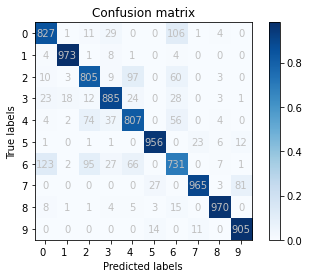

In [33]:
Xtest = np.reshape(X_test, (10000,784))/255
y_pred = F.feedForward(Xtest)
y_test_pred = np.argmax(y_pred, axis=0)
plotConfusionMatrixUpd(y_test_pred, Y_test)